This is a demonstration of how to capture frames from training videos and feed into the Pretrained Inception-V3 to extract 2048 dimensional feature vector. This is just the preprocessing step done on all the 400 training videos.

**Note**: Enable internet on kernel settings to download the weights for Inception-V3

In [1]:
# Importing the required libraries

import cv2
import numpy as np
import pandas as pd
import os
import glob
import pickle
import time
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image

In [2]:
# Version

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('OpenCV version:', cv2.__version__)

Tensorflow version: 2.1.0-rc0
OpenCV version: 4.1.2


In [3]:
# Initializing the paths

input_path = '/kaggle/input/deepfake-detection-challenge/'
train_dir = glob.glob(input_path + 'train_sample_videos/*.mp4')
test_dir = glob.glob(input_path + 'test_videos/*.mp4')

In [4]:
# Reading the labels of training data

df_train = pd.read_json(input_path + 'train_sample_videos/metadata.json').transpose()
df_train.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


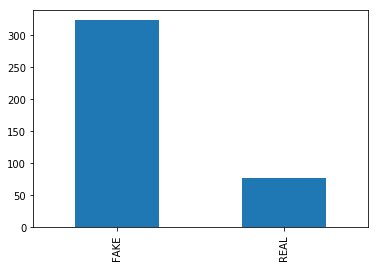

In [5]:
# Plotting the count of labels

# Fake class is in majority
df_train.label.value_counts().plot.bar()

In [6]:
# Taking the base model as Inception V3 and initializing its weight with imagenet

# Enable internet on kernel settings
input_tensor = Input(shape = (229, 229, 3))
cnn_model = InceptionV3(input_tensor = input_tensor, weights = 'imagenet', include_top = False, pooling = 'avg')
cnn_model.summary()

87916544/87910968 [==============================] - 29s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 229, 229, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 114, 114, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 114, 114, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 114, 114, 32) 0           batch_normalization[0][0]        
_____________________

In [7]:
# Creating 40 frames per video, resizing it to (229, 229, 3) and feeding it to Pretrained Inception-V3 to extract features
# Extracted features are stored in cnn_output

t = time.time()
cnn_output = {}
# count1 = 0
for v in train_dir:
    t1 = time.time()
    folder_name = v.split('/')[5]
    cap = cv2.VideoCapture(v)
    count = 0
    while count < 40:
        cap.set(cv2.CAP_PROP_POS_MSEC,(count * 250))   
        ret, frame = cap.read()
        frame = cv2.resize(frame, (229, 229))
        x = image.img_to_array(frame)
        x = np.expand_dims(x, axis = 0)
        x = preprocess_input(x)
        result = cnn_model.predict(x)
        if folder_name not in cnn_output.keys():
            cnn_output[folder_name] = []
        cnn_output[folder_name].append(list(result))
        count = count + 1
#     count1 += 1
#     print('Elapsed: ', time.time() - t1, ' | ', count1, '/', len(train_dir), ' | ', v)
print('Total elapsed: ', time.time() - t)

Total elapsed:  11232.79803109169


In [8]:
# Saving the cnn_output

os.mknod('cnn_output.txt')
with open('cnn_output.txt', 'wb') as f:
    pickle.dump(cnn_output, f)

In [9]:
# # Retrieving the cnn_output

# with open('cnn_output.txt', 'rb') as f:
#     cnn_output = pickle.load(f)